# Imports

In [1]:
import torch
from src.data_utils.dataloader import PokemonDataset
from matplotlib import pyplot as plt
import torchvision
import os
import numpy as np

# go back to the root directory
os.chdir('..')


# Explore data

## Different pokemon generations and games

In [2]:
root_dir = 'data/processed'  
save_dir = 'figures/data_stats/'

In [3]:
# Check all the generations and games in the processed data

all_games_dict = {}

for gen_folder in os.listdir(root_dir):
    generation = gen_folder.split('_')[-1]
    all_games_dict[generation] = []
    for game_folder in os.listdir(os.path.join(root_dir, gen_folder)):
        all_games_dict[generation].append(game_folder)

# print dictionary pretty
for gen in all_games_dict:
    print(f"Generation {gen.split('_')[-1]}:")
    for game in all_games_dict[gen]:
        print(f'  - {game}')

Generation generation-1:
  - red-blue
  - red-green
  - yellow
Generation generation-2:
  - crystal
  - gold
  - silver
Generation generation-3:
  - emerald
  - firered-leafgreen
  - ruby-sapphire
Generation generation-4:
  - diamond-pearl
  - heartgold-soulsilver
  - platinum
Generation generation-5:
  - black-white


## Count

Total count

In [4]:
# total count
dataset = PokemonDataset(root_dir)
print(f'Total number of Pokemons in the dataset: {len(dataset)}')

Total number of Pokemons in the dataset: 13318


Count per game and label

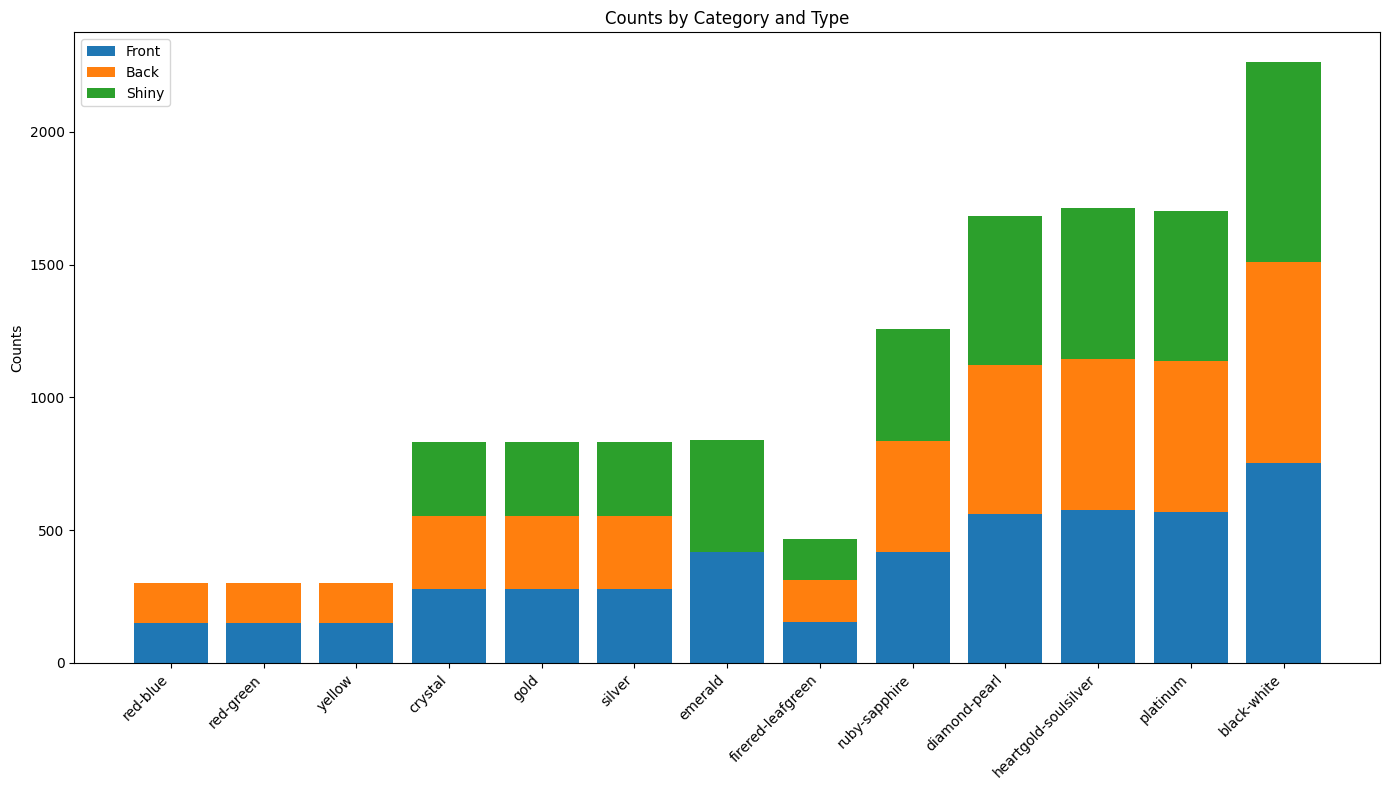

In [5]:
# We want to look at all labels
labels = ['front', 'back', 'shiny'] 

# list of all games
all_games = [game for games in all_games_dict.values() for game in games]

# Loop through all games and make dataset class
# Note: The PokemonDataset class should be modified to accept a list of games if it doesn't already
datasets = {game: {label: PokemonDataset(root_dir, labels=[label], games=[game]) for label in labels} for game in all_games}

# Get length of each dataset
lengths = {game: {label: len(datasets[game][label]) for label in labels} for game in all_games}

# Extracting keys and subkeys
keys = list(lengths.keys())
subkeys = list(lengths[keys[0]].keys())

# Preparing data for stacking in barplot
front_values = [lengths[key]['front'] for key in keys]
back_values = [lengths[key]['back'] for key in keys]
shiny_values = [lengths[key]['shiny'] for key in keys]

# Plotting
fig, ax = plt.subplots(figsize=(14, 8))

# Stacking bars
ax.bar(keys, front_values, label='Front')
ax.bar(keys, back_values, bottom=front_values, label='Back')
bottom_values = [f+b for f, b in zip(front_values, back_values)]
ax.bar(keys, shiny_values, bottom=bottom_values, label='Shiny')

# Customizing plot
ax.set_ylabel('Counts')
ax.set_title('Counts by Category and Type')
ax.set_xticks(range(len(keys)))
ax.set_xticklabels(keys, rotation=45, ha="right")
ax.legend()

# Display the plot
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "hist_category_type.png"))
plt.show()


See that some games do not have all labels

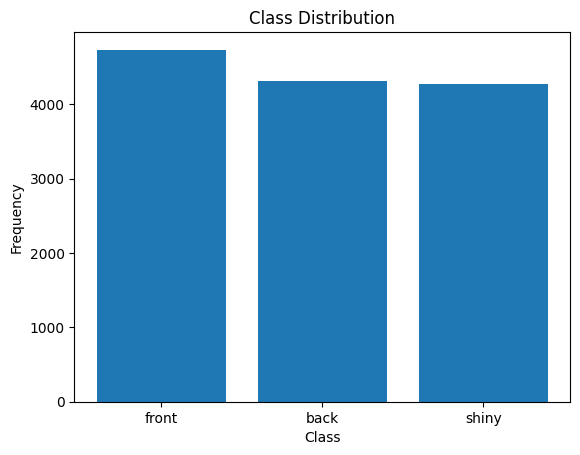

In [6]:
from collections import Counter

def plot_class_distribution(dataset):
    labels = [label for _, label in dataset]
    counter = Counter(labels)
    plt.bar(counter.keys(), counter.values())
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.savefig(os.path.join(save_dir, "hist_class_dist.png"))
    plt.show()
    
plot_class_distribution(dataset)

## Image samples from each class

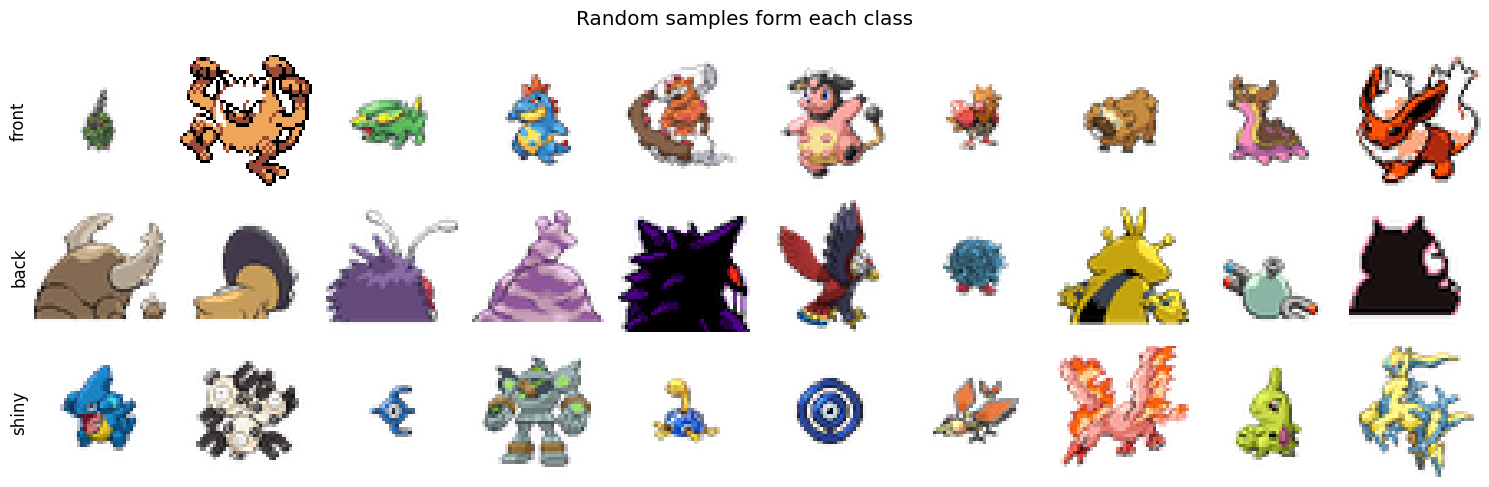

In [7]:
dataset_labels = ['front', 'back', 'shiny']
all_data_dataset = PokemonDataset(root_dir, labels=dataset_labels)


datasets = [PokemonDataset(root_dir, labels=[label]) for label in dataset_labels]

# Number of images in a batch
batch_size = 10

# Create a figure with 3 rows and batch_size columns
fig, axs = plt.subplots(len(datasets), batch_size, figsize=(15, 5))  # Adjust figure size as needed
for i, (ds, label) in enumerate(zip(datasets, labels)):
    dataloader = torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=True)
    
    # Get one batch of images
    images, _ = next(iter(dataloader))
    
    for j, img in enumerate(images):
        ax = axs[i, j]  # Select the subplot
        ax.imshow(img.permute(1, 2, 0))  # Assuming the images are in CxHxW format
        # ax.axis('off')  # Hide axes

        # axis ticks off
        ax.set_xticks([]) 
        ax.set_yticks([])
        # axis frame off
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        
        # Set the label for the first column
        if j == 0:
            ax.set_ylabel(label, size='large')

plt.suptitle('Random samples form each class', size='x-large')

# Adjust the layout
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "random_samples.png"))
plt.show()

## Image stats

In [8]:
def image_stats(dataset):
    dims = []
    channels_sum, channels_squared_sum = torch.zeros(3), torch.zeros(3)
    num_images = len(dataset)

    for i in range(num_images):
        img, _ = dataset[i]  # Assuming each element is a tuple (image, label)
        C, H, W = img.shape
        dims.append((H, W))

        # Sum and squared sum for each channel
        channels_sum += img.reshape(C, -1).sum(axis=1).numpy()
        channels_squared_sum += (img ** 2).reshape(C, -1).sum(axis=1).numpy()

    mean = channels_sum / (num_images * H * W)
    std = torch.sqrt(channels_squared_sum / (num_images * H * W) - mean ** 2)

    return dims, mean, std

dims, mean, std = image_stats(dataset)
print("Mean of channels:", mean)
print("Standard deviation of channels:", std)


Mean of channels: tensor([0.8533, 0.8305, 0.8147])
Standard deviation of channels: tensor([0.2581, 0.2747, 0.3025])


## Size distribution
Note that we already resized all images to 40x40 pixels.

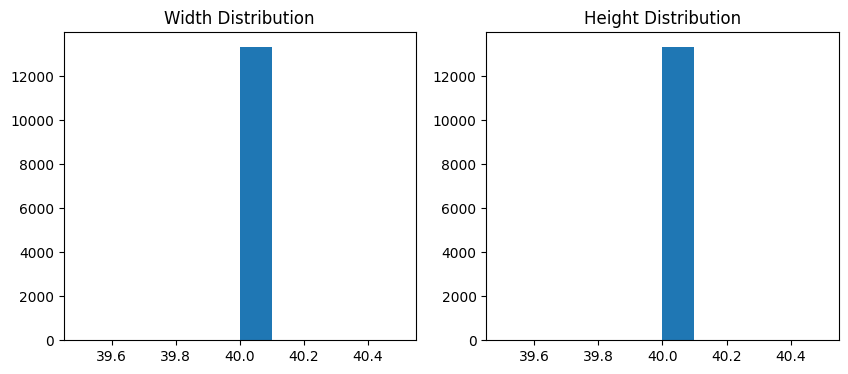

In [9]:
def plot_size_distribution(dims):
    widths, heights = zip(*dims)
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.hist(widths)
    plt.title('Width Distribution')
    plt.subplot(1, 2, 2)
    plt.hist(heights)
    plt.title('Height Distribution')
    plt.show()

plot_size_distribution(dims)

## t-SNE visualization of flattened images

In [ ]:
from sklearn.manifold import TSNE

def plot_tsne_with_labels(dataset, n=1000):
    # Randomly sample data
    indices = np.random.choice(range(len(dataset)), n, replace=False)
    sampled_data = [dataset[i] for i in indices]
    images, labels = zip(*sampled_data)

    # Convert images to a suitable format for t-SNE
    flattened_images = np.array([img.reshape(-1).numpy() for img in images])

    # Convert categorical labels to integers
    unique_labels = sorted(set(labels))
    label_to_int = {label: i for i, label in enumerate(unique_labels)}
    int_labels = [label_to_int[label] for label in labels]

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=0)
    tsne_results = tsne.fit_transform(flattened_images)

    # Plotting
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=int_labels, cmap='viridis', s=10)
    plt.colorbar(scatter, ticks=range(len(unique_labels)), label='Labels')
    plt.title('t-SNE visualization of image dataset')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.show()

# Adjust the sample size 'n' as needed
plot_tsne_with_labels(dataset, n=1000)